# Predicting GroundState Energy from Coulomb Matrices

This [dataset](https://www.kaggle.com/datasets/burakhmmtgl/energy-molecule) contains ground state energies of 16,242 molecules calculated by quantum mechanical simulations.

The data contains 1277 columns. The first 1275 columns are entries in the Coulomb matrix that act as molecular features. The 1276th column is the Pubchem Id where the molecular structures are obtained. The 1277th column is the atomization energy calculated by simulations using the Quantum Espresso package.

In the csv file, the first column (X1) is the data index.

The dataset was used for a [publication using a tree based ML Framework](https://arxiv.org/pdf/1609.07124.pdf).

## Getting the data

In this test we do NOT use PyTorch DataLoaders. Instead, we fabricate the batched tensors by hand and ensure that the data is accessed correctly by the training loop.

We create a class that inherits from torch's `Dataset` class to create our own dataset object. It must include the three given methods.

In [9]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np


In [10]:
def GS_from_CM_Dataset(path_to_data, transform=None):
    if os.path.exists(path_to_data):
        data = pd.read_csv(path_to_data)
    else:
        raise FileExistsError('No dataset found')
    data = data.sample(frac=1)
    X = data.drop(columns=['id', 'pubchem_id', 'Eat'])
    y = data['Eat']
    
    return torch.tensor(X.to_numpy()).to(torch.float), torch.tensor(y.to_numpy()).to(torch.float)

In [11]:
dataset = GS_from_CM_Dataset(path_to_data='data/GS_from_CM/GS_from_CM_data.csv')
N_all = len(dataset[0])
subset = 0.9

X_train, y_train, X_test, y_test = \
    dataset[0][:int(N_all*subset)], dataset[1][:int(N_all*subset)], dataset[0][int(N_all*subset):], dataset[1][int(N_all*subset):]
N_train = X_train[0].shape[0]
# print(datatrain[0].shape[0] + datatest[1].shape[0], dataset[0].shape[0])
# print(datatrain[0].shape, datatrain[1].shape, datatest[0].shape, datatest[1].shape)


def tensorBatch(tensor, batch_size):
    """I think this only works for one and two dimensional tensors
    Returns the batched tensor
    """
    N_batch = tensor.shape[0] // batch_size
    N_elems = N_batch * batch_size
    
    return tensor[:N_elems].reshape(N_batch, batch_size, -1).squeeze(), N_batch

batch_size = 128

# Check that it works. I think it does.
print(X_train.shape, tensorBatch(X_train, batch_size)[0].shape)
print(y_train.shape, tensorBatch(y_train, batch_size)[0].shape)
print(X_test.shape, tensorBatch(X_test, batch_size)[0].shape)
print(y_test.shape, tensorBatch(y_test, batch_size)[0].shape)

X_train, N_batch = tensorBatch(X_train, batch_size)
y_train, _ = tensorBatch(y_train, batch_size)
# X_test, y_test = [tensorBatch(tens, batch_size) for tens in test_data]

train_data = (X_train, y_train)
test_data = (X_test, y_test)

input_len = X_train.shape[-1]

torch.Size([14617, 1275]) torch.Size([114, 128, 1275])
torch.Size([14617]) torch.Size([114, 128])
torch.Size([1625, 1275]) torch.Size([12, 128, 1275])
torch.Size([1625]) torch.Size([12, 128])


Now we can start to build our NN.

In [12]:
from torch import nn

class SimpleNN(nn.Module):
    
    def __init__(self):
        super(SimpleNN, self).__init__()
        # The input is a 1275 vector
        self.linear_relu_block = nn.Sequential(
            nn.Linear(input_len, 16, bias=False),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            )
    
    def forward(self, x):
        logits = self.linear_relu_block(x)
        return logits.squeeze()
    
    
model = SimpleNN()
model.eval()  # I think it changes the setting for some layer types like dropout

# Check if it works
random_result = model(torch.rand(input_len))
print(random_result.shape)
# print(model(next(iter(train_dataloader))[0]).shape)

torch.Size([])


Now we can train the model. We use the SGD method, since I don't know how the rest work (TODO: Learn the others).

In [13]:
from random import shuffle

learning_rate = 1e-3
epochs = 20

SGD_opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
MSE_fn = nn.MSELoss()

def train_epoch(train_data, model, optimizer, loss_fn):
    idxs = np.arange(N_batch)
    shuffle(idxs)
    for batch, idx in enumerate(idxs):
        X, y = train_data[0][idx], train_data[1][idx]
        # Prediction and loss
        model.train()  # I think this is not required here, only for specific layers such as dropout
        y_pred = model(X)
        loss = loss_fn(y_pred, y.squeeze())
        
        # Calculate gradient and modify parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % (len(train_data[0]) // 10) == 0:
            print(f'Current {(batch + 1) * batch_size:6d} / {N_batch * batch_size:6d}. Train MSE = {loss:4.4f}', end='\r')
    return loss.item()

def test_epoch(test_data, model, loss_fn):
    # N = len(test_data.dataset)
    N = len(test_data[0])
    
    X, y = test_data
    
    N_batch = N // len(test_data[0])
    Mse = 0
    # with torch.no_grad():
    model.eval()
    # for X, y in test_data:
    y_pred = model(X)
    Mse += loss_fn(y_pred, y.squeeze()).item()
    print(f'\nTest MSE {Mse / N_batch:4.4f}')
    return Mse / N_batch

def train_loop(train_data, test_data, model, optimizer, loss_fn, epochs=1):
    train_mse = []
    test_mse = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        print('-'*50)
        
        tr_mse = train_epoch(train_data, model, optimizer, loss_fn)
        te_mse = test_epoch(test_data, model, loss_fn)
        
        train_mse.append(tr_mse)
        test_mse.append(te_mse)
    return [np.array(l) for l in (train_mse, test_mse)]

We have defined the model and its training loop. Let's put it to use

In [14]:
# train_mse, test_mse = train_loop(train_dataloader, test_dataloader, model, SGD_opt, MSE_fn, epochs=epochs)
from time import perf_counter

start = perf_counter()
train_mse, test_mse = train_loop(train_data, test_data, model, SGD_opt, MSE_fn, epochs=epochs)
end = perf_counter()

print(f'Run time for {epochs} epochs was {end - start:>4f} seconds.')


Epoch 1/20
--------------------------------------------------
Current  14208 /  14592. Train MSE = 38.27508
Test MSE 29.7926

Epoch 2/20
--------------------------------------------------
Current  14208 /  14592. Train MSE = 11.5052
Test MSE 13.0767

Epoch 3/20
--------------------------------------------------
Current  14208 /  14592. Train MSE = 12.1415
Test MSE 13.0714

Epoch 4/20
--------------------------------------------------
Current  14208 /  14592. Train MSE = 13.0583
Test MSE 13.0661

Epoch 5/20
--------------------------------------------------
Current  14208 /  14592. Train MSE = 12.3514
Test MSE 13.0711

Epoch 6/20
--------------------------------------------------
Current  14208 /  14592. Train MSE = 15.9126
Test MSE 13.0758

Epoch 7/20
--------------------------------------------------
Current  14208 /  14592. Train MSE = 13.3300
Test MSE 13.0748

Epoch 8/20
--------------------------------------------------
Current  14208 /  14592. Train MSE = 13.0094
Test MSE 13.0708

The method is much faster than using DataLoader from PyTorch.

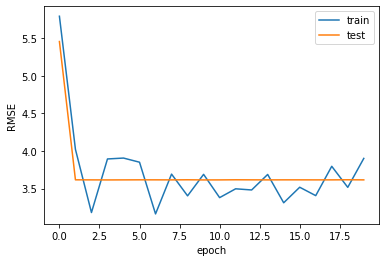

In [16]:
import matplotlib.pyplot as plt

plt.plot(np.sqrt(train_mse), label='train')
plt.plot(np.sqrt(test_mse), label='test')
plt.legend()
# plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('RMSE')

plt.show()